In [1]:
import sys
sys.version

'3.8.0 (default, Oct 28 2019, 16:14:01) \n[GCC 8.3.0]'

In [4]:
import numpyro as npr
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import numpy as np, random

In [5]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

## A general way of building a hierarchical model

In [6]:
def eight_schools(J, sigma, y=None):
    mu = npr.sample('mu', dist.Normal(0,5))
    tau = npr.sample('tau', dist.HalfCauchy(5))
    with npr.plate('J', J):
        theta = npr.sample('theta', dist.Normal(mu, tau))
        obs = npr.sample('obs', dist.Normal(theta, sigma), obs=y)

In [7]:
mcmc = MCMC(NUTS(eight_schools), num_warmup=1000, num_samples=2000)

data = dict(J=J, sigma=sigma, y=y)
mcmc.run(random.PRNGKey(0), 
         **data, 
         extra_fields=('potential_energy',))

sample: 100%|██████████| 3000/3000 [00:07<00:00, 427.79it/s, 15 steps of size 1.82e-01. acc. prob=0.79]


In [8]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.42      3.21      4.30     -0.67      9.74    260.87      1.00
       tau      4.18      3.36      3.23      0.79      8.51    102.55      1.02
  theta[0]      6.54      6.02      5.99     -1.94     16.42    377.20      1.00
  theta[1]      4.96      4.69      4.80     -2.71     11.76    615.30      1.00
  theta[2]      3.70      5.50      3.88     -4.28     12.44    512.40      1.00
  theta[3]      4.83      5.14      4.69     -3.10     13.09    666.13      1.00
  theta[4]      3.57      4.81      3.70     -3.82     11.19    407.00      1.00
  theta[5]      4.13      4.98      4.03     -3.78     12.18    494.42      1.00
  theta[6]      6.76      5.39      6.24     -1.99     15.01    299.08      1.00
  theta[7]      4.94      5.53      4.72     -3.20     14.41    589.27      1.00

Number of divergences: 56


In [9]:
pe = mcmc.get_extra_fields()
pe

{'diverging': DeviceArray([False, False, False, ..., False, False, False], dtype=bool),
 'potential_energy': DeviceArray([52.17198 , 53.72358 , 55.03537 , ..., 51.379787, 52.664917,
              57.926353], dtype=float32)}

In [11]:
print('Expected log joint density = ', -pe['potential_energy'].mean())

Expected log joint density =  -55.079952


## Non-Centered Parameterization

### TransformReparam

In [12]:
from numpyro.infer.reparam import TransformReparam

def eight_schools_noncentered(J, sigma, y=None):
    mu = npr.sample('mu', dist.Normal(0,5))
    tau = npr.sample('tau', dist.HalfCauchy(5))   # this HalfCauchy may not be appropriate. Check first.
    with npr.plate('J', J):
        with npr.handlers.reparam(config={'theta': TransformReparam()}):
            theta = npr.sample('theta',
                              dist.TransformedDistribution(dist.Normal(0,1),
                                                          dist.transforms.AffineTransform(mu, tau)))
        npr.sample('obj', dist.Normal(theta, sigma), obs=y)

In [13]:
mcmc = MCMC(NUTS(eight_schools_noncentered), num_warmup=1000, num_samples=2000)

data = dict(J=J, sigma=sigma, y=y)
mcmc.run(random.PRNGKey(0), 
         **data, 
         extra_fields=('potential_energy',))

mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:07<00:00, 417.74it/s, 7 steps of size 4.09e-01. acc. prob=0.91] 


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
           mu      4.37      3.39      4.38     -0.92     10.14   1595.67      1.00
          tau      3.76      3.59      2.74      0.01      8.13   1150.29      1.00
theta_base[0]      0.32      0.98      0.33     -1.30      1.90   1319.11      1.00
theta_base[1]      0.12      0.93      0.13     -1.39      1.63   2200.80      1.00
theta_base[2]     -0.07      0.96     -0.10     -1.65      1.48   1320.89      1.00
theta_base[3]      0.09      0.94      0.09     -1.35      1.74   1887.54      1.00
theta_base[4]     -0.19      0.95     -0.21     -1.78      1.32   2137.79      1.00
theta_base[5]     -0.07      0.95     -0.08     -1.71      1.41   1640.70      1.00
theta_base[6]      0.34      0.95      0.33     -1.08      1.98   1175.54      1.00
theta_base[7]      0.11      0.96      0.11     -1.56      1.54   1935.12      1.00

Number of divergences: 0


In [14]:
pe = mcmc.get_extra_fields()
print('Expected log joint density = ', -pe['potential_energy'].mean())

Expected log joint density =  -46.208366


### LocScaleReparam
For the class of distributions with loc,scale paramaters such as Normal, Cauchy, StudentT, we also provide a `LocScaleReparam` reparameterizer to achieve the same purpose.

In [17]:
from numpyro.infer.reparam import LocScaleReparam

def eight_schools_noncentered(J, sigma, y=None):
    mu = npr.sample('mu', dist.Normal(0,5))
    tau = npr.sample('tau', dist.HalfCauchy(5))
    with npr.plate('J', J):
        with npr.handlers.reparam(config={'theta': LocScaleReparam()}):
            theta = npr.sample('theta',
                               dist.Normal(mu, tau))
        npr.sample('obj', dist.Normal(theta, sigma), obs=y)

In [18]:
mcmc = MCMC(NUTS(eight_schools_noncentered), num_warmup=1000, num_samples=2000)

data = dict(J=J, sigma=sigma, y=y)
mcmc.run(random.PRNGKey(0), 
         **data, 
         extra_fields=('potential_energy',))

mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:07<00:00, 418.48it/s, 15 steps of size 3.21e-01. acc. prob=0.75]



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
                 mu      4.57      3.28      4.75     -0.85      9.60    290.21      1.00
                tau      3.71      3.26      2.78      0.39      7.59    353.67      1.00
theta_decentered[0]      3.08      2.30      3.02     -0.95      6.60    493.34      1.00
theta_decentered[1]      2.50      2.18      2.54     -0.91      6.02    439.21      1.00
theta_decentered[2]      2.07      2.39      2.16     -1.47      6.25    444.07      1.00
theta_decentered[3]      2.42      2.23      2.44     -0.99      6.26    384.89      1.00
theta_decentered[4]      1.92      2.19      1.96     -1.49      5.71    455.05      1.00
theta_decentered[5]      2.15      2.21      2.32     -1.38      5.63    428.01      1.00
theta_decentered[6]      3.07      2.15      3.14     -0.44      6.43    505.45      1.00
theta_decentered[7]      2.43      2.35      2.56     -1.21      6.27    406.91      1.00

Number o

In [19]:
pe = mcmc.get_extra_fields()
print('Expected log joint density = ', -pe['potential_energy'].mean())

Expected log joint density =  -49.750336


### Just make explicit transform

In [17]:
from numpyro.infer.reparam import LocScaleReparam

def eight_schools_noncentered(J, sigma, y=None):
    mu = npr.sample('mu', dist.Normal(0,5))
    tau = npr.sample('tau', dist.HalfCauchy(5))
    with npr.plate('J', J):
        theta = npr.sample('theta',  dist.Normal(mu, tau))
        npr.sample('obj', dist.Normal(theta, sigma), obs=y)

In [18]:
mcmc = MCMC(NUTS(eight_schools_noncentered), num_warmup=1000, num_samples=2000)

data = dict(J=J, sigma=sigma, y=y)
mcmc.run(random.PRNGKey(0), 
         **data, 
         extra_fields=('potential_energy',))

mcmc.print_summary()

sample: 100%|██████████| 3000/3000 [00:07<00:00, 418.48it/s, 15 steps of size 3.21e-01. acc. prob=0.75]



                         mean       std    median      5.0%     95.0%     n_eff     r_hat
                 mu      4.57      3.28      4.75     -0.85      9.60    290.21      1.00
                tau      3.71      3.26      2.78      0.39      7.59    353.67      1.00
theta_decentered[0]      3.08      2.30      3.02     -0.95      6.60    493.34      1.00
theta_decentered[1]      2.50      2.18      2.54     -0.91      6.02    439.21      1.00
theta_decentered[2]      2.07      2.39      2.16     -1.47      6.25    444.07      1.00
theta_decentered[3]      2.42      2.23      2.44     -0.99      6.26    384.89      1.00
theta_decentered[4]      1.92      2.19      1.96     -1.49      5.71    455.05      1.00
theta_decentered[5]      2.15      2.21      2.32     -1.38      5.63    428.01      1.00
theta_decentered[6]      3.07      2.15      3.14     -0.44      6.43    505.45      1.00
theta_decentered[7]      2.43      2.35      2.56     -1.21      6.27    406.91      1.00

Number o

In [19]:
pe = mcmc.get_extra_fields()
print('Expected log joint density = ', -pe['potential_energy'].mean())

Expected log joint density =  -49.750336


## Prediction from test data

In [21]:
from numpyro.infer import Predictive

In [23]:
def new_school():
    mu = npr.sample('mu', dist.Normal(0,5))
    tau = npr.sample('tau', dist.HalfCauchy(5))
    return npr.sample('obs', dist.Normal(mu, tau))

predictive = Predictive(new_school, mcmc.get_samples(), )
samples_pred = predictive(random.PRNGKey(0))

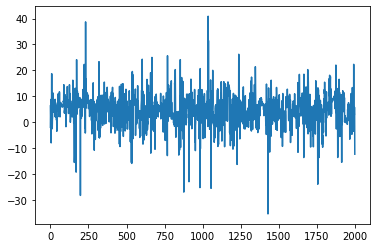

In [27]:
import matplotlib.pyplot as plt

plt.plot(samples_pred['obs'])

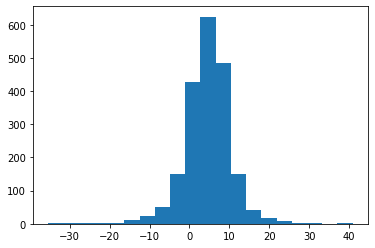

In [30]:
plt.hist(samples_pred['obs'], bins=20);

In [41]:
with npr.handlers.seed(rng_seed=0):
    x = npr.sample('x', dist.HalfCauchy(1), sample_shape=(10000,))
    print(x)

[0.06211887 1.186081   0.961785   ... 6.102715   1.2160733  0.8978999 ]


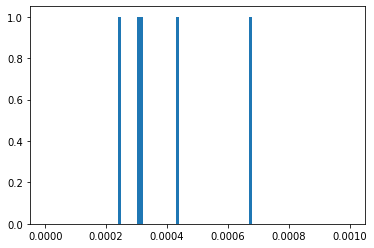

In [50]:
plt.hist(x,bins=100, range=[0, .001]);